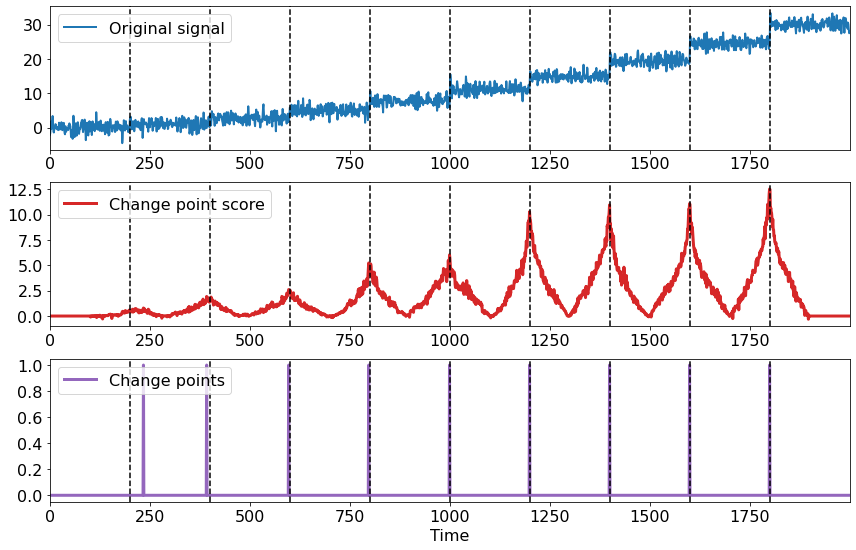

In [1]:
import roerich
from roerich.algorithms import ChangePointDetectionClassifier

# generate time series
X, cps_true = roerich.generate_dataset(period=200, N_tot=2000)

# detection
cpd = ChangePointDetectionClassifier()
score, cps_pred = cpd.predict(X)

# visualization
roerich.display(X, cps_true, score, cps_pred)

## CV

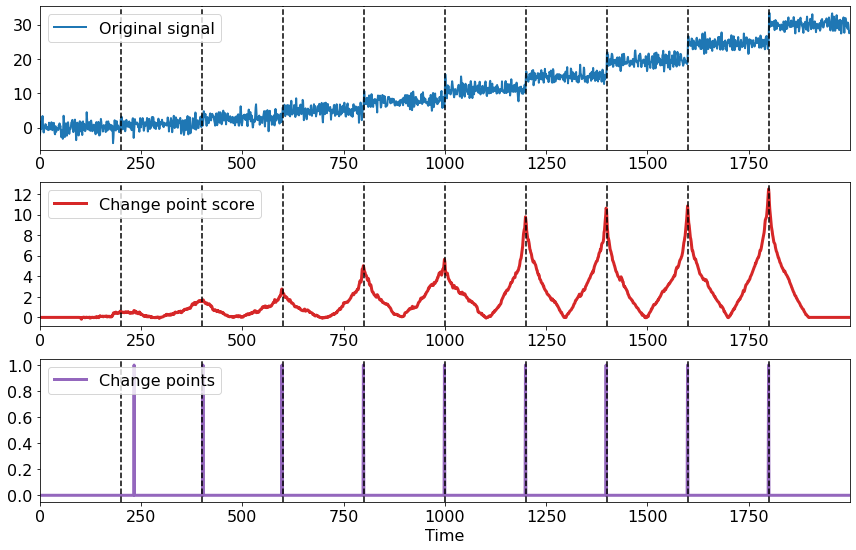

In [2]:
from roerich.algorithms import ChangePointDetectionClassifierCV

cpd = ChangePointDetectionClassifierCV(n_splits=5)
score, cps_pred = cpd.predict(X)

# visualization
roerich.display(X, cps_true, score, cps_pred)

# Bootstrap

In [3]:
from scipy.signal import argrelmax
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def get_stat(score):
    df = score.copy()
    
    cols = df.columns
    for i in df.index:
        df.loc[i, "Mean"] = df.loc[i][cols].mean()
        df.loc[i, "std"] = df.loc[i][cols].std()
        df.loc[i, "upper_b"] = df.loc[i, "Mean"] + 1.96*df.loc[i, "std"]
        df.loc[i, "lower_b"] = df.loc[i, "Mean"] - 1.96*df.loc[i, "std"]
    return df[["Mean", "std", "upper_b", "lower_b"]]

## ABS

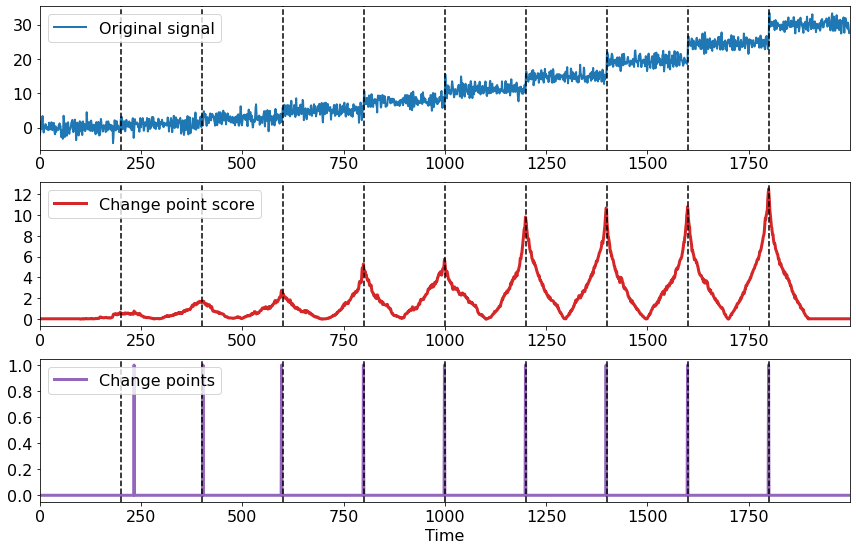

In [4]:
from roerich.algorithms import ChangePointDetectionClassifierABS

cpd = ChangePointDetectionClassifierABS(n_samples=50)
score_bs, cps_pred = cpd.predict(X)

bs_table = pd.DataFrame(score_bs).T
score = bs_table.median(axis=1).values
cps_pred = argrelmax(score, order=cpd.window_size)[0]

# visualization
roerich.display(X, cps_true, score, cps_pred)

In [5]:
stat = get_stat(bs_table)

x = list(stat.index)

fig = go.Figure([
    go.Scatter(
        x=x,
        y=stat["Mean"].values,
        line=dict(color='rgb(0,100,80)'),
        mode='lines',
        name="Original score"
    ),
    ### Scores on single plot
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(stat["upper_b"].values)+list(stat["lower_b"][::-1].values), # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False,
    )
])

fig.update_layout(
    title_text="Original score (Aleatoric Bootstrap)",
    xaxis_title="Time",
    yaxis_title="Score"
)

## EBS

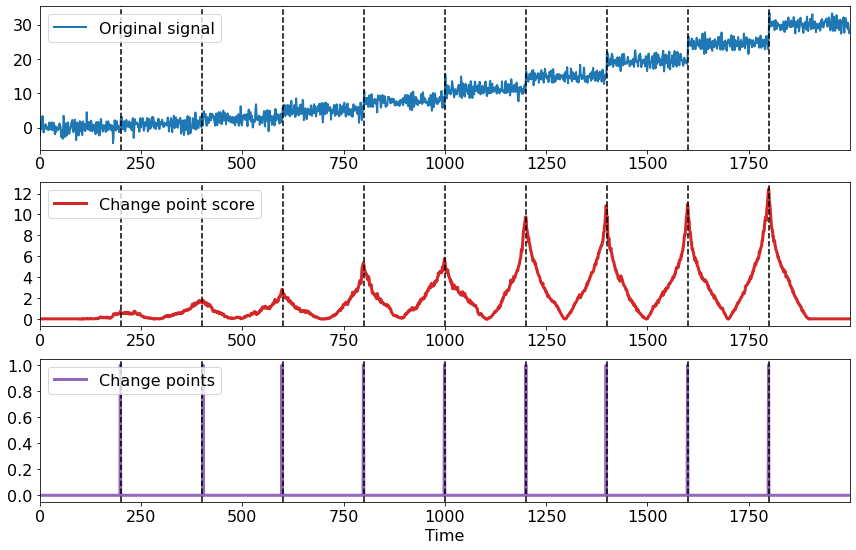

In [6]:
from roerich.algorithms import ChangePointDetectionClassifierEBS

cpd = ChangePointDetectionClassifierEBS(n_samples=50)
score_bs, cps_pred = cpd.predict(X)

bs_table = pd.DataFrame(score_bs).T
score = bs_table.median(axis=1).values
cps_pred = argrelmax(score, order=cpd.window_size)[0]

# visualization
roerich.display(X, cps_true, score, cps_pred)

In [7]:
stat = get_stat(bs_table)

x = list(stat.index)

fig = go.Figure([
    go.Scatter(
        x=x,
        y=stat["Mean"].values,
        line=dict(color='rgb(0,100,80)'),
        mode='lines',
        name="Original score"
    ),
    ### Scores on single plot
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(stat["upper_b"].values)+list(stat["lower_b"][::-1].values), # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False,
    )
])

fig.update_layout(
    title_text="Original score (Epistemic Bootstrap)",
    xaxis_title="Time",
    yaxis_title="Score"
)

## Energy Distance

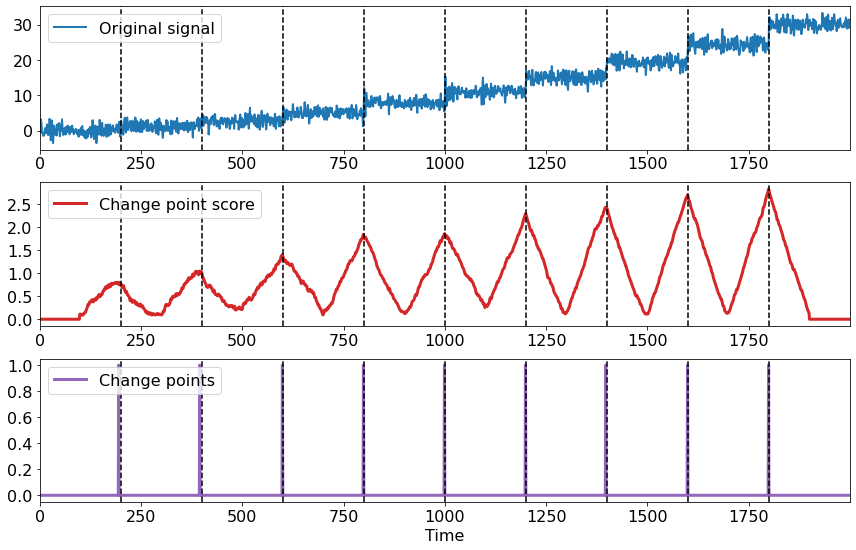

In [8]:
from roerich.algorithms import EnergyDistanceCalculator
import numpy as np

# generate time series
X, cps_true = roerich.generate_dataset(period=200, N_tot=2000)

# detection
cpd = EnergyDistanceCalculator()
score, cps_pred = cpd.predict(X)

# visualization
roerich.display(X, cps_true, np.sqrt(score), cps_pred)

# Matrix

In [9]:
import plotly.express as px
import numpy as np
import pandas as pd

def gen_synth(n_components=10, ts_lenght=3000, break_point=None, sigma=1):
    
    if break_point == None:
        break_point = ts_lenght//2

    df = pd.DataFrame()

    def gen_component(mean, delta, sigma, ts_lenght, break_point):
        first_half = np.random.normal(mean, sigma, break_point)
        second_half = np.random.normal(mean+delta, sigma, ts_lenght-break_point)

        resulted_ts = np.concatenate([first_half, second_half])

        assert ts_lenght == len(resulted_ts)

        return resulted_ts
    
    mean = 0
    delta = 0
    
    for i in range(1, n_components+1):
        
        df[f"c_{i}"] = gen_component(mean, delta, sigma, ts_lenght, break_point)
        
        delta += 0.2
        
    return df

## Union

In [10]:
from roerich.algorithms import MatrixUnionPairImportance

X = gen_synth()
cpd = ChangePointDetectionClassifier()

matrix = MatrixUnionPairImportance(X, cpd)

In [11]:
cut = np.round(matrix[:, :, 1500], 2)
n,m = cut.shape

fig = px.imshow(cut, x=np.arange(n), y=np.arange(m), text_auto=True)
fig.update_xaxes(side="top")

fig.update_layout(
    title_text="Union",
)

## Exclude

In [12]:
from roerich.algorithms import MatrixExcludePairImportance

X = gen_synth()
cpd = ChangePointDetectionClassifier()

matrix = MatrixExcludePairImportance(X, cpd)

In [13]:
cut = np.round(matrix[:, :, 1500], 2)
n,m = cut.shape

fig = px.imshow(cut, x=np.arange(n), y=np.arange(m), text_auto=True)
fig.update_xaxes(side="top")

fig.update_layout(
    title_text="Exclude",
)